In [167]:
import numpy as np
import sympy
import scipy

import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import tf2ss

import control as ct

from tqdm import tqdm

In [168]:
M = 0.4  # Масса тележки
m = 0.2  # Масса маятника
l = 0.25 # Длинна маятника
g = 9.8  # Ускорение свободного падения
f = 0.0  # Начальная сила 

# Уравнения объекта в форме Коши

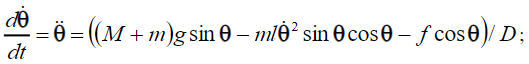
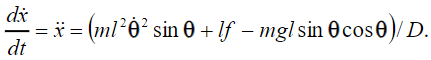

In [169]:
def koshi(y, t):
    """
    y - векрот состояния
        theta - угол
        dtheta - скрость имзменения угла
        x - положение в пространстве
        dx - скорость коретки 
    t - время 
    """
    theta, dtheta, x, dx = y
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    denominator = (M + m)*l - m*l*cos_theta**2
    
    ddtheta = ((M + m)*g*sin_theta - m*l*dtheta**2*sin_theta*cos_theta - f*cos_theta) / denominator
    ddx = (m*l**2*dtheta**2*sin_theta + l*f - m*g*l*sin_theta*cos_theta) / denominator
    
    return [dtheta, ddtheta, dx, ddx]

### Моделируем

In [170]:
def model(
        func, 
        theta0, 
        dtheta0, 
        ts=10, nt=0.1, x0 = 0.0, dx0 = 0.0
        ):
    """
    func - функция управления

    theta0 - начальный угол

    dtheta0 - начальная скорость изменения угла
    
    ts - время
    
    nt - шаг дискретизации времени
    
    x0 - начальная точка коретки
    
    dx0 - начальная скорость коретки
    """
    initial_conditions = [theta0, dtheta0, x0, dx0]
    t = np.arange(0, ts, nt)
    sol = odeint(func, initial_conditions, t)
    return sol

100%|██████████| 180/180 [00:14<00:00, 12.36it/s]


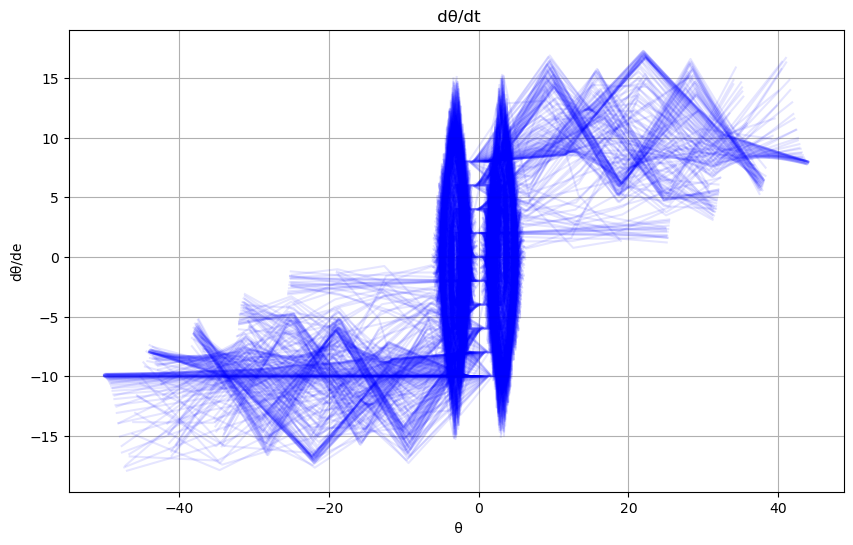

In [171]:
plt.figure(figsize=(10, 6))
    
radian_line = np.arange(
    np.radians(-180),
    np.radians(180),
    np.radians(2)
)

for theta0 in tqdm(radian_line):
    for dtheta0 in np.arange(-10, 10, 2):
        sol = model(koshi, theta0, dtheta0, 5, 1)
        plt.plot(sol[:, 0], sol[:, 1], 'b', alpha=0.1)  
    
plt.xlabel(' θ')
plt.ylabel('dθ/dе')
plt.title(' dθ/dt')
plt.grid()

plt.show()
    

# Моделирование физ модели

In [172]:
stats = model(koshi, 1, 0, 100, 0.1)

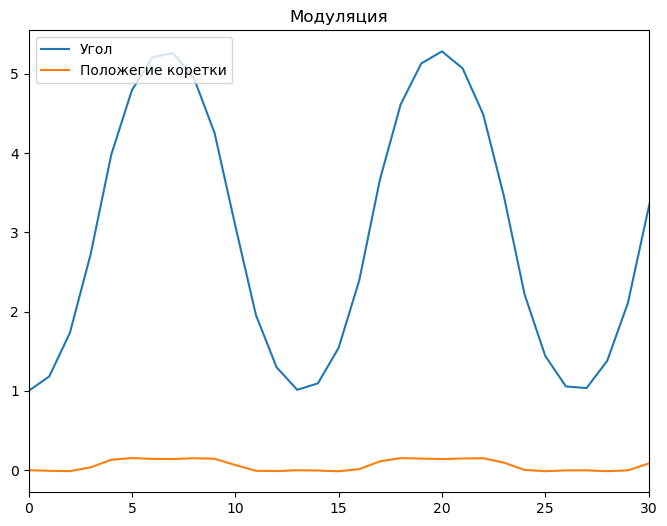

In [173]:
plt.figure(figsize=(8, 6))
plt.plot(stats[:, 0], label = 'Угол')
plt.plot(stats[:, 2], label = 'Положегие коретки')

plt.xlim(0, 30)

plt.legend(loc = 'upper left')


plt.title('Модуляция')
plt.show()

# Линеризация уравнений

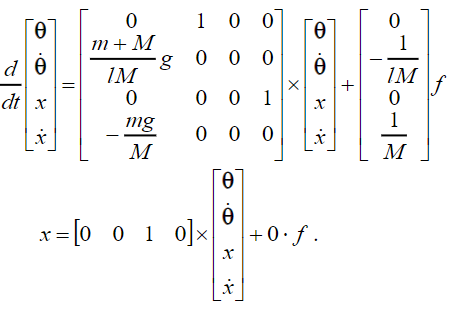
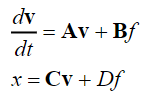

In [174]:
A = np.array([
    [0, 1, 0, 0],
    [(M+m)*g/(l*M), 0, 0, 0],
    [0, 0, 0, 1],
    [-m*g/M, 0, 0, 0]
])

B = np.array([
    [0], [-1/(l*M)], [0], [1/M]
    ])
C = np.array([[0, 0, 1, 0]])
D = np.array([[0]])

C_theta = np.array([[1, 0, 0, 0]])

## Передаточная функция

### Создаем систему

In [175]:
sys = ct.ss(A, B, C, D)
sys

StateSpace(array([[ 0. ,  1. ,  0. ,  0. ],
       [58.8,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. ],
       [-4.9,  0. ,  0. ,  0. ]]), array([[  0. ],
       [-10. ],
       [  0. ],
       [  2.5]]), array([[0., 0., 1., 0.]]), array([[0.]]))

In [176]:
G = ct.ss2tf(sys)
G

TransferFunction(array([ 1.74860126e-15,  2.50000000e+00,  4.61149518e-15, -9.80000000e+01]), array([  1. ,   0. , -58.8,   0. ,   0. ]))

In [177]:
A_s = G.num[0][0]
A_s

array([ 1.74860126e-15,  2.50000000e+00,  4.61149518e-15, -9.80000000e+01])

In [178]:
B_s = G.den[0][0]
B_s

array([  1. ,   0. , -58.8,   0. ,   0. ])

## Наблюдаемость

### Наблюдаемость по углу


In [179]:
nabl = ct.obsv(A, C_theta)
print(f"Рaзмер матрици наблюдаемости {nabl.shape}")
print(f"Ранг матрици наблюдаемости: {np.linalg.matrix_rank(nabl)}")

Рaзмер матрици наблюдаемости (4, 4)
Ранг матрици наблюдаемости: 2


Система не наблюдаема по углу

### Наблюдаемость по положению коретки

In [180]:
nabl = ct.obsv(A, C)
print(f"Рaзмер матрици наблюдаемости {nabl.shape}")
print(f"Ранг матрици наблюдаемости: {np.linalg.matrix_rank(nabl)}")

Рaзмер матрици наблюдаемости (4, 4)
Ранг матрици наблюдаемости: 4


Система наблюдаема по положению коретки

## Управляемсть

In [181]:
upr = ct.ctrb(A, B)

print(f"Ранг матрици упрвляемости: {np.linalg.matrix_rank(upr)}")

Ранг матрици упрвляемости: 4


Система управляема

# Анализ устойчивости положения равновесия

### Полюса и нули

In [182]:
poles = ct.poles(sys)
poles

array([ 0.        +0.j,  0.        +0.j,  7.66811581+0.j, -7.66811581+0.j])

In [183]:
zeros = ct.zeros(sys)
zeros

array([-6.26099034+0.j,  6.26099034+0.j])

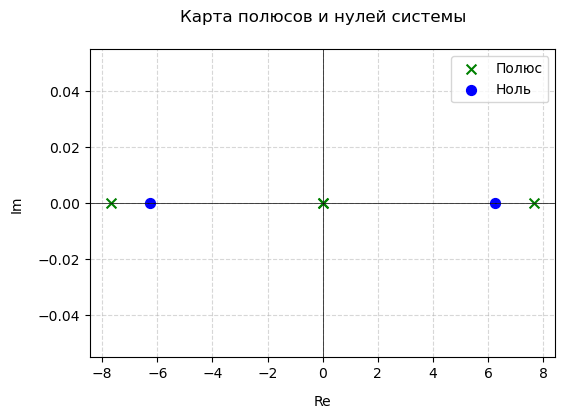

In [184]:
plt.figure(figsize=(6, 4))
plt.scatter(np.real(poles), np.imag(poles), marker='x', color='g', s=50, label='Полюс')
plt.scatter(np.real(zeros), np.imag(zeros), marker='o', color='b', s=50, label='Ноль')

plt.legend()

plt.axhline(0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(0, color='k', linestyle='-', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.5)

plt.title('Карта полюсов и нулей системы', pad=20)
plt.xlabel('Re', labelpad=10)
plt.ylabel('Im', labelpad=10)
plt.legend()

Системма не устойчева

# Синтез регулятора

### Задаем переменные

In [185]:
from sympy.abc import s
from sympy.physics.control.lti import TransferFunction as tf
from sympy.physics import control as sct

In [186]:
a_1, a_2, a_3, a_0 = sympy.symbols('a_1, a_2, a_3, a_0')
b_1, b_2, b_0 = sympy.symbols('b_1, b_2, b_0')

### Исходная функция системы

In [187]:
A_o = 1/M*(s**2-g/l)
B_o = (s**2*(s**2-(M+m)/(l*M)*g))
W_o = A_o/B_o
W_o

(2.5*s**2 - 98.0)/(s**2*(s**2 - 58.8))

### Функция регулятора

In [188]:
A_p = (a_3*s**3+a_2*s**2+a_1*s+a_0) 
B_p = (s**3+b_2*s**2+b_1*s+b_0)
W_p = A_p/B_p
W_p

(a_0 + a_1*s + a_2*s**2 + a_3*s**3)/(b_0 + b_1*s + b_2*s**2 + s**3)

In [189]:
A_s = A_o*B_p
B_s = A_o*A_p + B_o*B_p
W_s = sympy.together(A_s/B_s)
W_s

(2.5*s**2 - 98.0)*(b_0 + b_1*s + b_2*s**2 + s**3)/(s**2*(s**2 - 58.8)*(b_0 + b_1*s + b_2*s**2 + s**3) + (2.5*s**2 - 98.0)*(a_0 + a_1*s + a_2*s**2 + a_3*s**3))

In [190]:
a = [-0.2, -0.4, -1, -1.2247, -2, -4, -8]
polynom = sympy.prod(sympy.Array([s]*7)-sympy.Array(a))
polynom = sympy.cancel(polynom)
#polynom = (s + 1)**7
polynom

1.0*s**7 + 16.8247*s**6 + 98.18532*s**5 + 260.049276*s**4 + 341.47104*s**3 + 221.41752*s**2 + 63.9056*s + 6.270464

In [191]:
eq = sympy.Eq(B_s, polynom)
eq

Eq(s**2*(s**2 - 58.8)*(b_0 + b_1*s + b_2*s**2 + s**3) + (2.5*s**2 - 98.0)*(a_0 + a_1*s + a_2*s**2 + a_3*s**3), 1.0*s**7 + 16.8247*s**6 + 98.18532*s**5 + 260.049276*s**4 + 341.47104*s**3 + 221.41752*s**2 + 63.9056*s + 6.270464)

In [192]:
solv = sympy.solve(eq, [a_1, a_2, a_3, a_0, b_1, b_2, b_0])
solv

{a_0: -0.0639843265306122,
 a_1: -0.652097959183673,
 a_2: 1503.73195260441,
 a_3: 195.384451038734,
 b_0: -2509.98824551104,
 b_1: -331.475807596835,
 b_2: 16.8247000000000}

In [193]:
W_s = sympy.together(A_s/B_s).subs(solv)

In [194]:
a_0, a_1, a_2, a_3, b_0, b_1, b_2 = solv.values()

### Передаточная функция регулятора

In [195]:
W_p = tf((a_3*s**3+a_2*s**2+a_1*s+a_0) ,(s**3+b_2*s**2+b_1*s+b_0), var = s)
W_p

TransferFunction(195.384451038734*s**3 + 1503.73195260441*s**2 - 0.652097959183673*s - 0.0639843265306122, s**3 + 16.8247*s**2 - 331.475807596835*s - 2509.98824551104, s)

In [196]:
W_o = tf(1/M*(s**2-g/l), (s**2*(s**2-(M+m)/(l*M)*g)), var = s)
W_o

TransferFunction(2.5*s**2 - 98.0, s**2*(s**2 - 58.8), s)

## Анализ линейной системы 

### Передаточная функция замкнутой системы

In [197]:
W_s_ = sct.Feedback(W_o, W_p).doit(cancel=True, expand=True)
W_s_

TransferFunction(2.5*s**5 + 42.06175*s**4 - 926.689518992087*s**3 - 7923.79121377759*s**2 + 32484.6291444898*s + 245978.848060082, s**7 + 16.8247*s**6 + 98.18532*s**5 + 260.049276*s**4 + 341.471040000004*s**3 + 221.417520000017*s**2 + 63.9056*s + 6.270464, s)

### Cобственные значения замкнутой системы

In [198]:
W_s_den = W_s_.den
W_s_den

s**7 + 16.8247*s**6 + 98.18532*s**5 + 260.049276*s**4 + 341.471040000004*s**3 + 221.417520000017*s**2 + 63.9056*s + 6.270464

In [199]:
eq = sympy.Eq(W_s_den, 0)
eq

Eq(s**7 + 16.8247*s**6 + 98.18532*s**5 + 260.049276*s**4 + 341.471040000004*s**3 + 221.417520000017*s**2 + 63.9056*s + 6.270464, 0)

In [200]:
solv = sympy.solve(eq, s)
solv

[-7.99999999999999,
 -3.99999999999998,
 -2.00000000000134,
 -1.22469999999344,
 -1.00000000000574,
 -0.399999999999431,
 -0.200000000000074]

С учетом погрешности корни совпадают

##  Компьютерное моделирование нелинейной системы 
 


### Матрица параметров

In [201]:
W_p_num = np.array(sympy.Poly(W_p.num, s).all_coeffs()).astype(np.float32)
W_p_den = np.array(sympy.Poly(W_p.den, s).all_coeffs()).astype(np.float32)

In [202]:
A_, B_, C_, D_ = tf2ss(W_p_num, W_p_den)

#### Регулятор

In [203]:
reg = ct.ss(A_, B_, C_, D_)
reg

StateSpace(array([[-1.68246994e+01,  3.31475800e+02,  2.50998828e+03],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00]]), array([[1.],
       [0.],
       [0.]]), array([[ -1783.55273438,  64764.5625    , 490412.59375   ]]), array([[195.38444519]]))

#### Ситема

In [204]:
sys

StateSpace(array([[ 0. ,  1. ,  0. ,  0. ],
       [58.8,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. ],
       [-4.9,  0. ,  0. ,  0. ]]), array([[  0. ],
       [-10. ],
       [  0. ],
       [  2.5]]), array([[0., 0., 1., 0.]]), array([[0.]]))

#### Система с регулятором

In [205]:
sys_reg = ct.feedback(sys, reg)
sys_reg

StateSpace(array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.88000000e+01,  0.00000000e+00,  1.95384445e+03,
         0.00000000e+00, -1.78355273e+04,  6.47645625e+05,
         4.90412594e+06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-4.90000000e+00,  0.00000000e+00, -4.88461113e+02,
         0.00000000e+00,  4.45888184e+03, -1.61911406e+05,
        -1.22603148e+06],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00, -1.68246994e+01,  3.31475800e+02,
         2.50998828e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
       

### Функции моделирования

In [206]:
def regul_sys(y, t):
    """
    y - векрот состояния
        theta - угол
        dtheta - скрость имзменения угла
        x - положение в пространстве
        dx - скорость коретки 
    t - время 
    """
    theta, dtheta, x, dx = y[0:4]
    reg_vect = y[4:]

    error_x = 0 - x
    f = (reg.C @ reg_vect + reg.D * error_x)[0][0]

    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    denominator = (M + m)*l - m*l*cos_theta**2
    
    ddtheta = ((M + m)*g*sin_theta - m*l*dtheta**2*sin_theta*cos_theta - f*cos_theta) / denominator
    ddx = (m*l**2*dtheta**2*sin_theta + l*f - m*g*l*sin_theta*cos_theta) / denominator
    
    dreg_vec = reg.A@reg_vect+reg.B.reshape(-1)*error_x

    return np.concatenate([[dtheta, ddtheta, dx, ddx], dreg_vec])


In [207]:
def model_reg(
        func, 
        theta0, 
        dtheta0, 
        ts=10, nt=0.1, x0 = 0.0, dx0 = 0.0
        ):
    """
    func - функция управления

    theta0 - начальный угол

    dtheta0 - начальная скорость изменения угла
    
    ts - время
    
    nt - шаг дискретизации времени
    
    x0 - начальная точка коретки
    
    dx0 - начальная скорость коретки
    """
    initial_conditions = np.array([theta0, dtheta0, x0, dx0, 0, 0, 0])
    t = np.arange(0, ts, nt)
    sol = odeint(func, initial_conditions, t)
    return sol

### Модуляция

In [208]:
stats = model_reg(regul_sys, 0.08, 0, 100, 0.1)

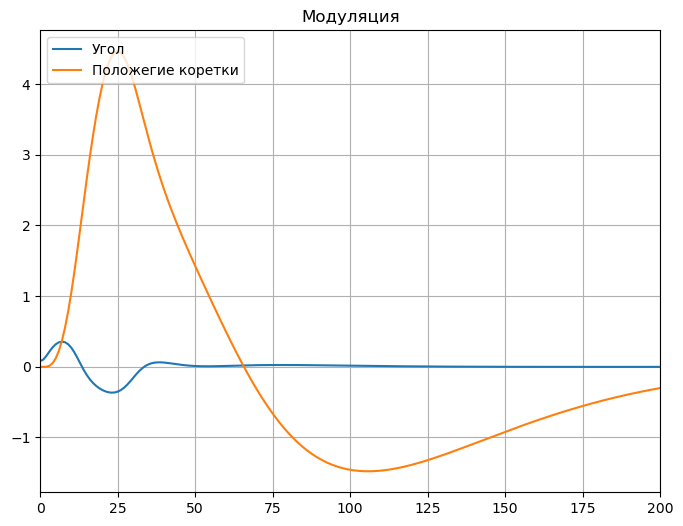

In [209]:
plt.figure(figsize=(8, 6))
plt.plot(stats[:, 0], label = 'Угол')
plt.plot(stats[:, 2], label = 'Положегие коретки')

plt.legend(loc = 'upper left')
plt.xlim(0, 200)
plt.grid()
plt.title('Модуляция')
plt.show()

# Синтез системы стабилизации перевернутого маятника 

## Метод размещения собственных значений 

### Линеаризация модели

In [210]:
A = np.array([
    [0, 1, 0, 0],
    [(M+m)*g/(l*M), 0, 0, 0],
    [0, 0, 0, 1],
    [-m*g/M, 0, 0, 0]
])

B = np.array([
    [0], [-1/(l*M)], [0], [1/M]
    ])
C = np.array([[0, 0, 1, 0]])
D = np.array([[0]])

### Cобственные значения системы

In [211]:
eig_A = np.linalg.eig(A)[0]
eig_A

array([ 0.        ,  0.        ,  7.66811581, -7.66811581])

### Желаемые значения

In [212]:
p =  np.array([
    -1, -2, -4, -7
])
p

array([-1, -2, -4, -7])

In [213]:
K = ct.place(A, B, p)
K

array([[-12.32285714,  -1.67040816,  -0.57142857,  -1.08163265]])

## Проведем анализ устойчивости системы

In [214]:
np.linalg.eig(A-B@K)[0]

array([-7., -4., -2., -1.])

Замкнутая система имеет желаемое расположение собственных значений.

### Hаблюдатель состояния

In [215]:
np.linalg.matrix_rank(ct.obsv(A, C))

4

система наблюдаема

In [216]:
po = 5*p
po

array([ -5, -10, -20, -35])

In [217]:
L = ct.place(A.T, C.T, po).T
L

array([[ -3544.08163265],
       [-26748.45714286],
       [    70.        ],
       [  1633.8       ]])

## Динамический  регулятор

In [218]:
def dynamic_reg(A, B, C, D, K, L):
    Ar = A - B @ K - L @ C
    Br = L
    Cr = -K
    Dr = np.zeros((K.shape[0], C.shape[0]))
    
    return Ar, Br, Cr, Dr

In [219]:
Ar, Br, Cr, Dr = dynamic_reg(A, B, C, D, K, L)

### Регулятор

In [220]:
regl = ct.ss(Ar, Br, Cr, Dr)
regl

StateSpace(array([[ 0.00000000e+00,  1.00000000e+00,  3.54408163e+03,
         0.00000000e+00],
       [-6.44285714e+01, -1.67040816e+01,  2.67427429e+04,
        -1.08163265e+01],
       [ 0.00000000e+00,  0.00000000e+00, -7.00000000e+01,
         1.00000000e+00],
       [ 2.59071429e+01,  4.17602041e+00, -1.63237143e+03,
         2.70408163e+00]]), array([[ -3544.08163265],
       [-26748.45714286],
       [    70.        ],
       [  1633.8       ]]), array([[12.32285714,  1.67040816,  0.57142857,  1.08163265]]), array([[0.]]))

In [221]:
np.linalg.eig(Ar)[0]

array([-55.00884284+52.10899229j, -55.00884284-52.10899229j,
        32.2791385  +0.j        ,  -6.26145283 +0.j        ])

Регулятор неустойчив —  имеется положительное собственное значение

### Передаточная функция регулятора

In [222]:
W_reg = ct.ss2tf(regl)

### Анализ системы с динамическим регулятором 

In [223]:
sys_reg_ = ct.feedback(sys, regl, sign=1)
sys_reg_

StateSpace(array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 5.88000000e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.23228571e+02, -1.67040816e+01,
        -5.71428571e+00, -1.08163265e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-4.90000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.08071429e+01,  4.17602041e+00,
         1.42857143e+00,  2.70408163e+00],
       [ 0.00000000e+00,  0.00000000e+00, -3.54408163e+03,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         3.54408163e+03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -2.67484571e+04,
         0.00000000e+00, -6.44285714e+01, -1.67040816e+01,
         2.67427429e+04, -1.08163265e+01],
       [ 0.00000000e+00

In [228]:
def regul_sys_(y, t):
    """
    y - векрот состояния
        x - положение в пространстве
        theta - угол
        dtheta - скрость имзменения угла
        dx - скорость коретки 
    t - время 
    """
    theta, dtheta, x, dx = y[0:4]
    reg_vect = y[4:]

    error_x = 0 - x
    f = (regl.C @ reg_vect + regl.D * error_x)[0][0]

    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    denominator = (M + m)*l - m*l*cos_theta**2
    
    ddtheta = ((M + m)*g*sin_theta - m*l*dtheta**2*sin_theta*cos_theta - f*cos_theta) / denominator
    ddx = (m*l**2*dtheta**2*sin_theta + l*f - m*g*l*sin_theta*cos_theta) / denominator
    
    dreg_vec = regl.A@reg_vect+regl.B.reshape(-1)*error_x
    
    return np.concatenate([[dtheta, ddtheta, dx, ddx], dreg_vec])

In [229]:
def model_reg_(
        func, 
        theta0, 
        dtheta0, 
        ts=10, nt=0.1, x0 = 0.0, dx0 = 0.0
        ):
    """
    func - функция управления

    theta0 - начальный угол

    dtheta0 - начальная скорость изменения угла
    
    ts - время
    
    nt - шаг дискретизации времени
    
    x0 - начальная точка коретки
    
    dx0 - начальная скорость коретки
    """
    initial_conditions = np.array([theta0, dtheta0, x0, dx0, 0, 0, 0, 0])
    t = np.arange(0, ts, nt)
    sol = odeint(func, initial_conditions, t)
    return sol

In [235]:
stats = model_reg_(regul_sys_, 0.03, 0, 100, 0.1)

C:\Users\Filic\AppData\Local\Temp\ipykernel_26708\2170400250.py:24: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(func, initial_conditions, t)


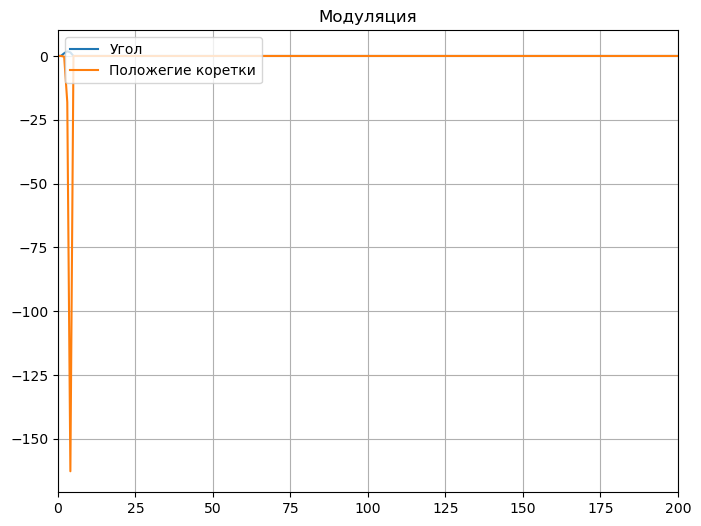

In [237]:
plt.figure(figsize=(8, 6))
plt.plot(stats[:, 0], label = 'Угол')
plt.plot(stats[:, 2], label = 'Положегие коретки')

plt.legend(loc = 'upper left')
plt.xlim(0, 200)

plt.grid()
plt.title('Модуляция')
plt.show()

# Модели систем с цифровыми управляющими устройствами 